<a href="https://colab.research.google.com/github/Ran147/Project_T/blob/main/Fase3_ver_2FR_face_recognition__estudiantes_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: [Johan Rodríguez](https://github.com/Johanx22x)

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [ ]:
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
!pip install pytz
import datetime
import pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=a64e4ab99af54196ccc0ce494143391b0ba2becf67887f01feac25f408a24579
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


# Utils

## In-memory data

In [ ]:
import pickle

In [ ]:
registered_faces = {}
registered_professor = []
registered_student = []
registered_miscelaneous = []
registered_class = []
registered_course = []
registered_attendance = []
registered_students_in_courses = []

In [ ]:
attendance_list0 = []
attendance_list2 = []
attendance_list3 = []

In [ ]:
with open('caritas.bin', 'ab') as file:
  pickle.dump(registered_faces, file)


##Save info

In [ ]:
local_tz = pytz.timezone('America/Costa_Rica')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('caritas.bin', 'rb') as file:
  sumito = pickle.load(file)
registered_faces.update(sumito)
with open("infoprofesores.bin", "rb") as file:
  informaciondelprofesorado = pickle.load(file)
  for pr in informaciondelprofesorado:
    registered_professor.append(pr)
with open("infoestudiantes.bin", "rb") as file:
  informaciondelestudiantado = pickle.load(file)
  for es in informaciondelestudiantado:
    registered_student.append(es)
with open("infomisc.bin", "rb") as file:
  informaciondelmiscelaneado = pickle.load(file)
  for mi in informaciondelmiscelaneado:
    registered_miscelaneous.append(mi)
with open("infoaulas.bin", "rb") as file:
  informaciondelaula = pickle.load(file)
  for au in informaciondelaula:
    registered_class.append(au)
with open("infocursos.bin", "rb") as file:
  informaciondelcurso = pickle.load(file)
  for cu in informaciondelcurso:
    registered_course.append(cu)



In [ ]:
class Estudiante:
    def __init__(self, name, id, age, birthday, nationality, phone_number, emails, address, carreer, marital_status):
        self.name = name
        self.id = id
        self.age = age
        self.birthday = birthday
        self.nationality = nationality
        self.phone_number = phone_number
        self.emails = emails
        self.address = address
        self.carreer = carreer
        self.marital_status = marital_status
class Profesor:
  def __init__(self, name, id, age, birthday, nationality, phone_number, emails, address, specialty, marital_status):
        self.name = name
        self.id = id
        self.age = age
        self.birthday = birthday
        self.nationality = nationality
        self.phone_number = phone_number
        self.emails = emails
        self.address = address
        self.specialty = specialty
        self.marital_status = marital_status

class Miscelaneo:
  def __init__(self, name, id, age, birthday, nationality, phone_number, emails, address, schedule, marital_status):
        self.name = name
        self.id = id
        self.age = age
        self.birthday = birthday
        self.nationality = nationality
        self.phone_number = phone_number
        self.emails = emails
        self.address = address
        self.schedule = schedule
        self.marital_status = marital_status

class Aula:
  def __init__(self, numero_aula, condicion, sillas, limpieza):
    self.numero_aula = numero_aula
    self.condicion = condicion
    self.sillas = sillas
    self.limpieza = limpieza

class Curso:
  def __init__(self, codigo_curso, nombre_curso, periodo, carrera, lista_estudiantes, lista_profesores, horario, aula):
    self.codigo_curso = codigo_curso
    self.nombre_curso = nombre_curso
    self.periodo = periodo
    self.carrera = carrera
    self.lista_estudiantes = lista_estudiantes
    self.lista_profesores = lista_profesores
    self.horario = horario
    self.aula = aula







In [ ]:
class Asistencia:
  def __init__(self, nombre, path, hora):
    self.nombre = nombre
    self.path = path
    self.hora = hora

## face recognition

In [ ]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## Real time streaming

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [ ]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register profesor, student, miscelaneous, classroom and course

## Registrar rostro de profesores

In [ ]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)


### Registrar informacion de profesores

In [ ]:
def profesor():
  ''' A function that receives all the information about teachers to them stored it in a list.
      Arguments:
        (teacher) ---{dict} --- Dictionary
      Returns:
        (registered_professor) ---{list} --- List of dictionaries
  '''
  # Asks the user to input the following information
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  age = int(input("Age: "))
  print("")
  nationality = input("Nationality: ")
  print("")
  # Creates a dictionary for the phone numbers
  phonebook = {}
  # Start a loop to input phone numbers
  while True:
    name = input("Enter contact name: ")
    print("")
    phone_number = input("Enter phone number: ")
    # Adds the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Asks the user if they want to add another phone number
    print("")
    another = input("Do you want to add another phone number? (yes/no): ")

    # Checks if the user wants to stop
    if another != 'yes':
        break
  print("")
  # Creates a list for the emails
  email_list = []
  # Starts a loop to input emails
  while True:
    email = input("Enter an email address: ")
    # Adds the email to the list
    email_list.append(email)
    print("")
    # Asks the user if they want to add another email
    another_email = input("Do you want to add another email? (yes/no): ")
    # Checks if the user wants to stop
    if another_email != "yes":
      break
  print("")
  address = input("Address: ")
  print("")
  specialty = input("Specialty: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  elprofesor = Profesor(registered_name, id,age, birthday, nationality, phonebook, email_list, address, specialty, marital_status)
  # Load existing student information, if any
  try:
    with open("infoprofesores.bin", "rb") as file:
      profes = pickle.load(file)
  except FileNotFoundError:
        profes = []

  profes.append(elprofesor)  # Append the new student to the list

    # Save the updated list back to the file
  with open("infoprofesores.bin", "wb") as file:
      pickle.dump(profes, file)




# Calls the function
profesor()

Enter the identification: 9398383

Birthday: idnind
Age: 36

Nationality: aregentinian

Enter contact name: mesu

Enter phone number: 9938382

Do you want to add another phone number? (yes/no): yes
Enter contact name: ien

Enter phone number: 939388

Do you want to add another phone number? (yes/no): no

Enter an email address: forvis@gmail.com

Do you want to add another email? (yes/no): no

Address: ddwkek

Specialty: dribbles

Marital status: married



In [ ]:
with open("infoprofesores.bin", "rb") as file:
  informaciondelprofesorado = pickle.load(file)
  for pr in informaciondelprofesorado:
    registered_professor.append(pr)

In [ ]:
print(registered_professor)
for h in registered_professor:
  print(h.name)

Messi 


## Registrar rostro de estudiantes

In [ ]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)



### Registrar informacion de estudiantes

In [ ]:
def estudiante():
  ''' A function that receives all the information about students to them stored it in a list.
      Arguments:
        (student) ---{dict} --- Dictionary
      Returns:
        (registered_student) ---{list} --- List of dictionaries
  '''
  # Asks the user to input the following information
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  age = int(input("Age: "))
  print("")
  nationality = input("Nationality: ")
  print("")
  # Creates a dictionary for the phone numbers
  phonebook = {}
  # Starts a loop to input phone numbers
  while True:
    name = input("Enter contact name: ")
    print("")
    phone_number = input("Enter phone number: ")
    print("")
    # Adds the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Asks the user if they want to add another phone number
    another = input("Do you want to add another phone number? (yes/no): ")
    # Checks if the user wants to stop
    if another != 'yes':
        break
  print("")
  # Creates a list for the emails
  email_list = []
  # Starts a loop to input emails
  while True:
    email = input("Enter an email address: ")
    # Adds the email to the list
    email_list.append(email)
    print("")
    # Asks the user if they want to add another email
    another_email = input("Do you want to add another email? (yes/no): ")
    # Checks if the user wants to stop
    if another_email != "yes":
      break
  print("")
  address = input("Adress")
  print("")
  carreer = input("Carreer: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  # Adds all the information asked to the main dictionary
  elestudiante = Estudiante(registered_name, id,age, birthday, nationality, phonebook, email_list, address, carreer, marital_status)
  # Load existing student information, if any
  try:
    with open("infoestudiantes.bin", "rb") as file:
      estus = pickle.load(file)
  except FileNotFoundError:
        estus = []

  estus.append(elestudiante)  # Append the new student to the list

    # Save the updated list back to the file
  with open("infoestudiantes.bin", "wb") as file:
      pickle.dump(estus, file)

# Calls the function
estudiante()

Enter the identification: diwnindi3

Birthday: diw
Age: 38

Nationality: portuguese

Enter contact name: nid

Enter phone number: 4948388

Do you want to add another phone number? (yes/no): yes
Enter contact name: suiuu

Enter phone number: 9338378

Do you want to add another phone number? (yes/no): no

Enter an email address: sindn@gmail.com

Do you want to add another email? (yes/no): no

Adresskdnin

Carreer: ing computtatino

Marital status: married



In [ ]:
with open("infoestudiantes.bin", "rb") as file:
  informaciondelestudiantado = pickle.load(file)
  for es in informaciondelestudiantado:
    registered_student.append(es)

In [ ]:
print(registered_student)
for c in registered_student:
  print(c.name)

[<__main__.Estudiante object at 0x7ccd87763d30>, <__main__.Estudiante object at 0x7ccd87762950>]
Randy
Cristiano


## Registrar miscelaneos

In [ ]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)


### Registrar informacion de miscelaneos

In [ ]:
def miscelaneous():
  ''' A function that receives all the information about miscelaneous to them stored it in a list.
      Arguments:
        (xperson) ---{dict} --- Dictionary
      Returns:
        (registered_miscelaneous) ---{list} --- List of dictionaries
  '''
 # Asks the user to input the following information
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  age = int(input("Age: "))
  print("")
  nationality = input("Nationality: ")
  print("")
  # Creates a dictionary for the phone numbers
  phonebook = {}
  # Starts a loop to input phone numbers
  while True:
    name = input("Enter contact name: ")
    print("")
    phone_number = input("Enter phone number: ")
    print("")
    # Adds the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Asks the user if they want to add another phone number
    another = input("Do you want to add another phone number? (yes/no): ")
    # Checks if the user wants to stop
    if another != 'yes':
        break
  print("")
  # Creates a list for the emails
  email_list = []
  # Starts a loop to input emails
  while True:
    email = input("Enter an email address: ")
    # Adds the email to the list
    email_list.append(email)
    print("")
    # Asks the user if they want to add another email
    another_email = input("Do you want to add another email? (yes/no): ")
    # Checks if the user wants to stop
    if another_email != "yes":
      break
  address = input("Adress")
  print("")
  schedule = input("shift: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  # Adds all the information asked to the main dictionary
  elmiscelaneo = Miscelaneo(registered_name, id,age, birthday, nationality, phonebook, email_list, address, schedule, marital_status)
  # Load existing student information, if any
  try:
    with open("infomisc.bin", "rb") as file:
      misce = pickle.load(file)
  except FileNotFoundError:
        misce = []

  misce.append(elmiscelaneo)  # Append the new student to the list

    # Save the updated list back to the file
  with open("infomisc.bin", "wb") as file:
      pickle.dump(misce, file)

# Calls the function
miscelaneous()

Enter the identification: 38389921

Birthday: idind
Age: 58

Nationality: south african

Enter contact name: sndi

Enter phone number: 38372

Do you want to add another phone number? (yes/no): no

Enter an email address: businnes@gmail.com

Do you want to add another email? (yes/no): no
Adressdwnd

shift: Day

Marital status: married



In [ ]:
with open("infomisc.bin", "rb") as file:
  informaciondelmiscelaneado = pickle.load(file)
  for mi in informaciondelmiscelaneado:
    registered_miscelaneous.append(mi)

In [ ]:
print(registered_miscelaneous)
for ct in registered_miscelaneous:
  print(ct.name)

Elon


## Registrar aulas

In [ ]:
def classroom():
  ''' A function that receives all the information about classroom to them stored it in a list.
      Arguments:
        (classrum) ---{dict} --- Dictionary
        (registered_miscelaneous) ---{list} --- List of dictionaries created before
      Returns:
        (registered_class) ---{list} --- List of dictionaries
  '''
 # Creates a list an a dictionary to store information
  schedule_list = []
  final_dict = {}
 # Asks the user to input the following information
  classnum = input("Write the number of the classroom: ")
  print("")
  classcondition = input("The classroom has Air conditioning? (yes/no)")
  chairstate = input("Are the chairs in good condition? (yes/no)")
  # Starts a loop to input cleaning schedules
  while True:
    cleaning = input("Write the schedule assigned for cleaning the classroom: ")
    # Adds the cleaning schedule to the list
    schedule_list.append(cleaning)
    # Asks the user if they want to add another cleaning schedule
    another_schedule = input("Do you want to add another day? (yes/no): ")
    # Checks if the user wants to stop
    if another_schedule != "yes":
      break

  misceasignado = input("Write the name of the miscelaneous in charge: ")
  # Starts a loop to travel through the registered_miscelaneous list
  for i in registered_miscelaneous:
    name = i.name
    # Checks if the miscelaneous exist in set list
    if misceasignado != name:
      print("The miscelaneous doesn't exist")
    else:
      # Adds the miscelaneous to the dictionary
      final_dict[misceasignado] = schedule_list
  elaula = Aula(classnum, classcondition, chairstate, final_dict)
  # Load existing student information, if any
  try:
    with open("infoaulas.bin", "rb") as file:
      aulitas = pickle.load(file)
  except FileNotFoundError:
        aulitas = []

  aulitas.append(elaula)  # Append the new student to the list

    # Save the updated list back to the file
  with open("infoaulas.bin", "wb") as file:
      pickle.dump(aulitas, file)

# Calls the function
classroom()

Write the number of the classroom: A12

The classroom has Air conditioning? (yes/no)no
Are the chairs in good condition? (yes/no)yes
Write the schedule assigned for cleaning the classroom: 1pm-3pm
Do you want to add another day? (yes/no): no
Write the name of the miscelaneous in charge: Elon


In [ ]:
with open("infoaulas.bin", "rb") as file:
  informaciondelaula = pickle.load(file)
  for au in informaciondelaula:
    registered_class.append(au)

In [ ]:

print(registered_class)
for rc in registered_class:
  print(rc.limpieza)

{'Elon': ['1pm-3pm']}


## Registrar cursos

In [ ]:
def course():
  ''' A function that receives all the information about course to them stored it in a list.
      Arguments:
        (course_info) ---{dict} --- Dictionary
        (registered_professor) ---{list} --- List of dictionaries created before
        (registered_student) ---{list} --- List of dictionaries created before
        (registered_miscelaneous) ---{list} --- List of dictionaries created before
      Returns:
        (course_info) ---{list} --- List of dictionaries
  '''
 # Asks the user to input the following information
  code = input("Write the code of the course: ")
  print("")
  coursename = input("Write the name of the course: ")
  print("")
  period = input("Write the period of the course: ")
  print("")
  career = input("Write the career to which the course belongs: ")
  print("")

 # Creates some lists an a dictionary to store information
  studcourse = {}
  students_list = []

  schedule_list = []
  classroom_list = []

  # Starts a loop to input the students
  while True:
    students_in = input("Write the enrolled student: ")
  # Starts a loop to travel through the registered_student list
    for students in registered_student:
      stuname = students.name
      # Checks if the student exist in set list
      if students_in != stuname:
        continue
      else:
        # Adds the student to the list
        students_list.append(students_in)
    # Asks the user if they want to add another student
    another_student1 = input("Do you want to add another student? (yes/no)")
    # Checks if the user wants to stop
    if another_student1 != "yes":
        break

  teachers_list = []
  while True:
    print("")
    teachers_in = input("Write the assigned teacher: ")
  # Starts a loop to travel through the registered_professor list
    for x in registered_professor:
      profname = x.name
    # Checks if the teacher exist in set list
      if teachers_in.strip() != profname.strip():
        continue
      else:
        # Adds the teacher to the list
        teachers_list.append(teachers_in)
    # Asks the user if they want to add another teacher
    another_teacher1 =input("Do you want to add another teacher? (yes/no)")
    # Checks if the user wants to stop
    if another_teacher1 != "yes":
      break

  # Starts a loop to input the schedules
  while True:
    print("")
    schedule = input("Enter the day of the course: ")
    # Adds the schedule to the list
    schedule_list.append(schedule)
    print("")
    # Asks the user if they want to add another schedule
    another_schedule = input("Do you want to add another day? (yes/no): ")
    print("")
    # Checks if the user wants to stop
    if another_schedule != "yes":
      break

  # Starts a loop to input the classrooms
  while True:
    classroom_in = input("Write the assigned classroom: ")
    print("")
  # Starts a loop to travel through the registered_class list
    for classroom in registered_class:
      number = classroom.numero_aula
      # Checks if the classroom exist in set list
      if classroom_in != number:
        continue
      else:
        # Adds the classroom to the list
        classroom_list.append(classroom_in)
    # Asks the user if they want to add another classroom
    another_classroom1 =input("Do you want to add another classroom? (yes/no)")
    # Checks if the user wants to stop
    if another_classroom1 != "yes":
        break

  elcurso = Curso(code, coursename, period, career, students_list, teachers_list, schedule_list, classroom_list)
  # Load existing student information, if any
  try:
    with open("infocursos.bin", "rb") as file:
      cursito = pickle.load(file)
  except FileNotFoundError:
        cursito = []

  cursito.append(elcurso)  # Append the new student to the list

    # Save the updated list back to the file
  with open("infocursos.bin", "wb") as file:
      pickle.dump(cursito, file)

  studcourse[code] = students_list
  # Adds the students list to another list
  registered_students_in_courses.append(studcourse)

# Calls the function
course()

Write the code of the course: IC001

Write the name of the course: Introduction to programming

Write the period of the course: ndii

Write the career to which the course belongs: sxw

Write the enrolled student: Randy
Do you want to add another student? (yes/no)yes
Write the enrolled student: Cristiano
Do you want to add another student? (yes/no)no

Write the assigned teacher: Messi
Do you want to add another teacher? (yes/no)no

Enter the day of the course: monday

Do you want to add another day? (yes/no): no

Write the assigned classroom: A12

Do you want to add another classroom? (yes/no)no


In [ ]:
with open("infocursos.bin", "rb") as file:
  informaciondelcurso = pickle.load(file)
  for cu in informaciondelcurso:
    registered_course.append(cu)

In [ ]:
print(registered_course)
for cur in registered_course:
  print(cur.lista_profesores)
print(registered_students_in_courses)


['Messi']
[{'IC001': ['Randy', 'Cristiano']}]


In [ ]:
registered_course.clear()
registered_students_in_courses.clear()

# Take attendance

## Report of Attendance

In [ ]:
consulta9lista = []
consulta9 = {}
consulta6lista = []
consulta6 = {}
consulta11lista = []
consulta11 = {}
# List to store attendance dictionaries

while True:
    numeration = input("Write the code of the course you would like to take attendance (or 'q' to quit): ")

    # Check if the user wants to quit
    if numeration.lower() == 'q':
        break

    video_stream()

    # label for video
    label_html = 'Capturing...'
    bbox = ''
    js_reply = video_frame(label_html, bbox)

    # Check if there's a response from the camera
    if js_reply:
        # Convert JS response to OpenCV Image
        img = js_to_image(js_reply["img"])
        imgname = input("Write the name of the image")
        img_path = '/content/drive/MyDrive/Almacen de fotos/' + imgname + '.jpg'
        cv2.imwrite(img_path, img)

        # Get the current time
        current_time = datetime.datetime.now(local_tz).strftime("%Y-%m-%d %H")

        # Draw the current time on the frame
        cv2.putText(
            img,
            current_time,
            (10, 30),  # Position to display the time (you can adjust this)
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,  # Font scale
            (0, 0, 0),  # Text color (white)
            2,  # Thickness of the text
            cv2.LINE_AA,
        )

        # Get the face locations from the frame
        face_locations = face_recognition.face_locations(img)

        # For each face in the frame
        for (top, right, bottom, left) in face_locations:
            # Draw a rectangle around the face
            cv2.rectangle(
                img,
                (left, top),
                (right, bottom),
                (0, 0, 255),
                2,
            )
            # Get the face encoding of the face
            face_encoding = face_recognition.face_encodings(img, [(top, right, bottom, left)])[0]

            # Compare the face encoding to the faces in the database
            matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

            # If there is a match
            if True in matches:
                # Get the index of the match
                match_index = matches.index(True)

                # Get the name of the match
                match_name = list(registered_faces.keys())[match_index]
                face_info = top, right, bottom, left
                ate = []
                ate.append(match_name)
                consulta9lista.append(match_name)
                consulta11lista.append(match_name)
                ate.append(img_path)
                ate.append(face_info)
                ate.append(current_time)
                consulta6lista.append(ate)
                lasistencia = Asistencia(match_name, img_path, current_time)
                # Load existing student information, if any
                try:
                  with open("infoasistencia.bin", "rb") as file:
                    asis = pickle.load(file)
                except FileNotFoundError:
                      asis = []

                asis.append(lasistencia)  # Append the new student to the list

                  # Save the updated list back to the file
                with open("infoasistencia.bin", "wb") as file:
                    pickle.dump(asis, file)


                # Draw the name of the match on the frame
                cv2.putText(
                    img,
                    match_name,
                    (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 255),
                    2,
                    cv2.LINE_AA,
                )
            else:
                # Draw "Unknown" on the frame
                cv2.putText(
                    img,
                    "Unknown",
                    (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 255),
                    2,
                    cv2.LINE_AA,
                )

        # Show image
        plt.imshow(img)
        plt.show()

        # Append the course attendance dictionary to the list
        if len(attendance_list2) == 0:
            consulta9[numeration] = consulta9lista
            attendance_list2.append(consulta9)
        else:
            found = False  # Flag to check if numeration exists in any dictionary in attendance_list2
            for dictionary in attendance_list2:
                if numeration in dictionary:
                    for element in consulta9lista:
                        dictionary[numeration].append(element)
                    found = True  # Set the flag to True if numeration is found
                    break  # No need to continue searching once we found numeration
            if not found:
                new_dict = {numeration: consulta9lista}
                attendance_list2.append(new_dict)

        if len(attendance_list0) == 0:
            consulta6[numeration] = consulta6lista
            attendance_list0.append(consulta6)
        else:
            found = False  # Flag to check if numeration exists in any dictionary in attendance_list2
            for dictionary in attendance_list0:
                if numeration in dictionary:
                    for element in consulta6lista:
                        dictionary[numeration].append(element)
                    found = True  # Set the flag to True if numeration is found
                    break  # No need to continue searching once we found numeration
            if not found:
                new_dict = {numeration: consulta6lista}
                attendance_list0.append(new_dict)
        # Check if the time already exists in attendance_list3
        for entry in attendance_list3:
            if current_time in entry:
                if numeration in entry[current_time]:
                    # Append the names from consulta11lista
                    entry[current_time][numeration].extend(consulta11lista)
                else:
                    # Create a new course entry
                    entry[current_time][numeration] = consulta11lista
                break
        else:
            # If the time doesn't exist, create a new entry
            attendance_list3.append({current_time: {numeration: consulta11lista}})


# Print the list of attendIC0ASCance dictionaries
print(attendance_list0)

In [ ]:
with open("infoasistencia.bin", "rb") as file:
  informaciondelasistenciado = pickle.load(file)
  for ar in informaciondelasistenciado:
    registered_attendance.append(ar)

In [ ]:
print(registered_attendance)
for g in registered_attendance:
  print(g.nombre)

[<__main__.Asistencia object at 0x7ccdc28cf5e0>, <__main__.Asistencia object at 0x7ccd0d08fe50>, <__main__.Asistencia object at 0x7ccd0d08eaa0>]
Randy
Cristiano
Messi 


In [ ]:
print(attendance_list0)

[{'IC001': [['Cristiano', '/content/drive/MyDrive/Almacen de fotos/IUS.jpg', (242, 655, 428, 469), '2023-10-22 16'], ['Messi ', '/content/drive/MyDrive/Almacen de fotos/ASC.jpg', (329, 370, 403, 295), '2023-10-22 16'], ['Randy', '/content/drive/MyDrive/Almacen de fotos/ranz.jpg', (170, 562, 491, 241), '2023-10-22 17']]}]



## Didn't recognize your face? Run this and go to the previous line to try again

In [ ]:
attendance_list0.clear()
attendance_list2.clear()
attendance_list3.clear()

#Consultas

## Consulta 1

In [ ]:

def print_teacher_info(teacher_list):
    for teacher in teacher_list:
          print("Teacher Information:")
          print(f"Name: {teacher.name}")
          print(f"ID: {teacher.id}")
          print(f"Age: {teacher.age}")
          print(f"Birthday: {teacher.birthday}")
          print(f"Nationality: {teacher.nationality}")
          print("Phone Book:")
          for phone_name, phone_value in teacher.phone_number.items():
              print(f"  {phone_name}: {phone_value}")
          print("Emails:")
          for email in teacher.emails:
              print(f"  {email}")
          print(f"Address: {teacher.address}")
          print(f"Specialty: {teacher.specialty}")
          print(f"Marital Status: {teacher.marital_status}\n")

# Call the function to print teacher information
print_teacher_info(registered_professor)

Teacher Information:
Name: Messi 
ID: 9398383
Age: 36
Birthday: idnind
Nationality: aregentinian
Phone Book:
  mesu: 9938382
  ien: 939388
Emails:
  forvis@gmail.com
Address: ddwkek
Specialty: dribbles
Marital Status: married



## Consulta 2

In [ ]:
def print_student_info(student_list):
    for student in student_list:
        print("Student Information:")
        print(f"Name: {student.name}")
        print(f"ID: {student.id}")
        print(f"Age: {student.age}")
        print(f"Birthday: {student.birthday}")
        print(f"Nationality: {student.nationality}")
        print("Phone Book:")
        for phone_name, phone_value in student.phone_number.items():
            print(f"  {phone_name}: {phone_value}")
        print("Emails:")
        for email in student.emails:
            print(f"  {email}")
        print(f"Address: {student.address}")
        print(f"Carreer: {student.carreer}")
        print(f"Marital Status: {student.marital_status}\n")

# Call the function to print student information
print_student_info(registered_student)


Student Information:
Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone Book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Carreer: ing computation
Marital Status: alone

Student Information:
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone Book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Carreer: ing computtatino
Marital Status: married



## Consulta 3

In [ ]:
def print_miscelaneo_info(miscelaneo_list):
    for miscelaneo in miscelaneo_list:
        print("Miscelaneo Information:")
        print(f"Name: {miscelaneo.name}")
        print(f"ID: {miscelaneo.id}")
        print(f"Age: {miscelaneo.age}")
        print(f"Birthday: {miscelaneo.birthday}")
        print(f"Nationality: {miscelaneo.nationality}")
        print("Phone Book:")
        for phone_name, phone_value in miscelaneo.phone_number.items():
            print(f"  {phone_name}: {phone_value}")
        print("Emails:")
        for email in miscelaneo.emails:
            print(f"  {email}")
        print(f"Address: {miscelaneo.address}")
        print(f"Schedule: {miscelaneo.schedule}")
        print(f"Marital Status: {miscelaneo.marital_status}\n")

# Call the function to print Miscelaneo information
print_miscelaneo_info(registered_miscelaneous)


Miscelaneo Information:
Name: Elon
ID: 38389921
Age: 58
Birthday: idind
Nationality: south african
Phone Book:
  sndi: 38372
Emails:
  businnes@gmail.com
Address: dwnd
Schedule: Day
Marital Status: married



## Consulta 4

In [ ]:
def print_class_info(class_list):
    for classr in class_list:
        print("Class Information:")
        print(f"Number of Classroom: {classr.numero_aula}")
        print(f"Condition: {classr.condicion}")
        print(f"Number of Chairs: {classr.sillas}")
        print("Cleaning:")
        for key, value in classr.limpieza.items():
            if isinstance(value, list):
                value = ', '.join(value)  # Convert the list to a comma-separated string
            print(f"  {key}: {value}")
        print()

# Call the function to print Aula information
print_class_info(registered_class)

Class Information:
Number of Classroom: A12
Condition: no
Number of Chairs: yes
Cleaning:
  Elon: 1pm-3pm



## Consulta 5

In [ ]:
def print_course_info(course_list):
    for course in course_list:
        print("Course Information:")
        print(f"Course Code: {course.codigo_curso}")
        print(f"Course Name: {course.nombre_curso}")
        print(f"Period: {course.periodo}")
        print(f"Career: {course.carrera}")

        print("Students:")
        for student_name in course.lista_estudiantes:
            for student in registered_student:
                if student.name == student_name:
                    print(f"  - Name: {student.name}")
                    print(f"    ID: {student.id}")
                    print(f"    Age: {student.age}")
                    print(f"Birthday: {student.birthday}")
                    print(f"Nationality: {student.nationality}")
                    print("Phone Book:")
                    for phone_name, phone_value in student.phone_number.items():
                        print(f"  {phone_name}: {phone_value}")
                    print("Emails:")
                    for email in student.emails:
                        print(f"  {email}")
                    print(f"Address: {student.address}")
                    print(f"Carreer: {student.carreer}")
                    print(f"Marital Status: {student.marital_status}\n")

                    # Add more student information as needed

        print("Professors:")
        for professor_name in course.lista_profesores:
            for professor in registered_professor:
                if professor.name.strip() == professor_name.strip():
                    print(f"  - Name: {professor.name}")
                    print(f"    ID: {professor.id}")
                    print(f"    Age: {professor.age}")
                    print(f"Nationality: {professor.nationality}")
                    print("Phone Book:")
                    for phone_name, phone_value in professor.phone_number.items():
                        print(f"  {phone_name}: {phone_value}")
                    print("Emails:")
                    for email in professor.emails:
                        print(f"  {email}")
                    print(f"Address: {professor.address}")
                    print(f"Specialty: {professor.specialty}")
                    print(f"Marital Status: {professor.marital_status}\n")
                    # Add more professor information as needed

        # Join the 'horario' and 'aula' lists to display them as strings
        horario = ', '.join(course.horario)
        aula = ', '.join(course.aula)
        print(f"Schedule: {horario}")
        print(f"Classroom: {aula}")
        print()

# Call the function to print Curso information
print_course_info(registered_course)






Course Information:
Course Code: IC001
Course Name: Introduction to programming
Period: ndii
Career: sxw
Students:
  - Name: Randy
    ID: 504470682
    Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone Book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Carreer: ing computation
Marital Status: alone

  - Name: Cristiano
    ID: diwnindi3
    Age: 38
Birthday: diw
Nationality: portuguese
Phone Book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Carreer: ing computtatino
Marital Status: married

Professors:
  - Name: Messi 
    ID: 9398383
    Age: 36
Nationality: aregentinian
Phone Book:
  mesu: 9938382
  ien: 939388
Emails:
  forvis@gmail.com
Address: ddwkek
Specialty: dribbles
Marital Status: married

Schedule: monday
Classroom: A12



## Consulta 6

Enter the course code: IC001
Course Code: IC001
Type: Student
Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Marital Status: alone
Attendance Time: 2023-10-23 14



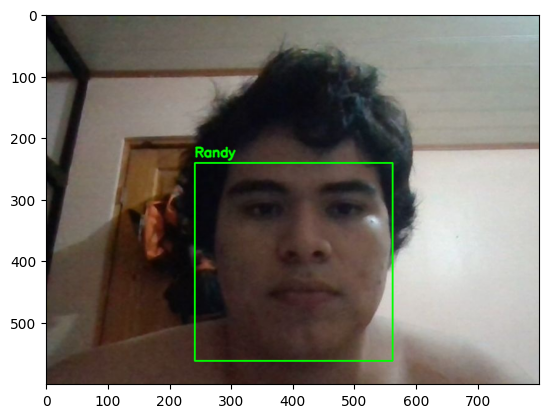

Type: Student
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Marital Status: married
Attendance Time: 2023-10-23 14



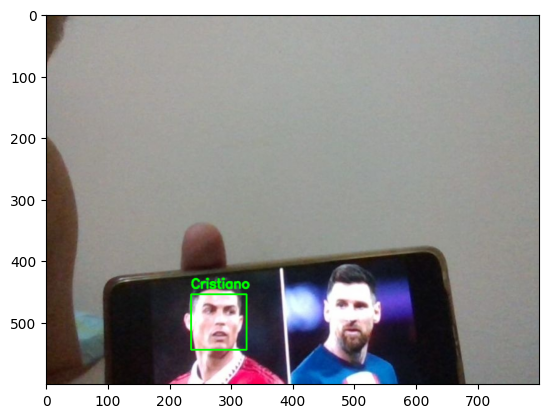

Type: Professor
Name: Messi 
ID: 9398383
Age: 36
Birthday: idnind
Nationality: aregentinian
Phone book:
  mesu: 9938382
  ien: 939388
Emails:
  forvis@gmail.com
Address: ddwkek
Marital Status: married
Attendance Time: 2023-10-23 14



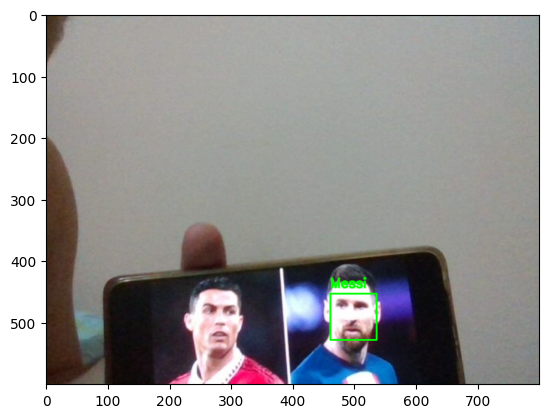

In [ ]:


def show_image(image_path, face_info=None):
    """
    This function displays an image with an optional square and name on the face.

    Args:
        image_path (str): Path to the image.
        face_info (tuple): Information about the face (top, right, bottom, left, name).
    Returns:
        None
    """
    img = cv2.imread(image_path)

    if face_info is not None:
        top, right, bottom, left, name = face_info
        # Draws a rectangle around the face
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

        # Adds the name above the face
        cv2.putText(
            img,
            name,
            (left, top - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

    img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    plt.show()


def consulta6():
    all_people = {}

    # Combine all the people instances into one list
    all_people_instances = registered_student + registered_professor + registered_miscelaneous

    for person in all_people_instances:
        all_people[person.name] = person

    course_code = input("Enter the course code: ")

    for attendance in attendance_list0:
        if course_code in attendance:
            attendance_list = attendance[course_code]
            print(f"Course Code: {course_code}")

            for person_info in attendance_list:
                name, img_path, (top, right, bottom, left), attendance_time = person_info

                if name in all_people:
                    person_instance = all_people[name]
                    person_type = "Student" if isinstance(person_instance, Estudiante) else "Professor" if isinstance(person_instance, Profesor) else "Miscellaneous"
                else:
                    person_type = "Unknown"
                    person_instance = None

                print(f"Type: {person_type}")

                if person_instance:
                    # Extract information directly from the instance
                    print(f"Name: {person_instance.name}")
                    print(f"ID: {person_instance.id}")
                    print(f"Age: {person_instance.age}")
                    print(f"Birthday: {person_instance.birthday}")
                    print(f"Nationality: {person_instance.nationality}")

                    # Print the contents of the Phone book without dictionary structure
                    print("Phone book:")
                    for phone_key, phone_value in person_instance.phone_number.items():
                        print(f"  {phone_key}: {phone_value}")

                    # Print the contents of the Emails without list structure
                    print("Emails:")
                    for email in person_instance.emails:
                        print(f"  {email}")

                    print(f"Address: {person_instance.address}")
                    print(f"Marital Status: {person_instance.marital_status}")

                print(f"Attendance Time: {attendance_time}")
                print()
                show_image(img_path, (top, right, bottom, left, name))
            break
    else:
        print(f"No attendance found for course code: {course_code}")

# Calls the function
consulta6()

## Consulta 7

In [ ]:
def bubble_sort_by_age(arr):
    n = len(arr)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            if arr[j].age > arr[j + 1].age:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]

def consul7():
    codig = input("Write the code of the course: ")
    enrolled_students = []

    # Iterate through registered students in courses then append the matching list
    for course_dict in registered_students_in_courses:
        if codig in course_dict:
            enrolled_students = course_dict[codig]

    # Verify if students are enrolled in the course
    if not enrolled_students:
        print("No students are enrolled in this course.")
    else:
        # Create a list to store student instances in the same order as enrolled_students
        sorted_students = []

        # Iterate through enrolled students and match the names with registered_student, then append the matching instance
        for student_name in enrolled_students:
            for student in registered_student:
                if student.name == student_name:
                    sorted_students.append(student)
                    break  # Exit the inner loop after finding a match

        # Sort the list of student instances by age using the bubble sort function
        bubble_sort_by_age(sorted_students)

        print("The enrolled students in this course from youngest to oldest are: ")
        # Print all the information of the students
        for student_instance in sorted_students:
            print(f"Name: {student_instance.name}")
            print(f"ID: {student_instance.id}")
            print(f"Age: {student_instance.age}")
            print(f"Birthday: {student_instance.birthday}")
            print(f"Nationality: {student_instance.nationality}")

            # Print the contents of the Phone book without dictionary structure
            print("Phone book:")
            for pb_key, pb_value in student_instance.phone_number.items():
                print(f"  {pb_key}: {pb_value}")

            # Print the contents of the Emails without list structure
            print("Emails:")
            for email in student_instance.emails:
                print(f"  {email}")

            print(f"Address: {student_instance.address}")
            print(f"Career: {student_instance.carreer}")
            print(f"Marital Status: {student_instance.marital_status}\n")

# Call the function
consul7()

Write the code of the course: IC001
The enrolled students in this course from youngest to oldest are: 
Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Career: ing computation
Marital Status: alone

Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Career: ing computtatino
Marital Status: married



## Consulta 8

In [ ]:

def insertion_sort_by_age(arr):
    for i in range(1, len(arr)):
        key = arr[i]
        j = i - 1
        while j >= 0 and key.age > arr[j].age:
            arr[j + 1] = arr[j]
            j -= 1
        arr[j + 1] = key

def consul7():
    codig = input("Write the code of the course: ")
    enrolled_students = []

    # Iterate through registered students in courses then append the matching list
    for course_dict in registered_students_in_courses:
        if codig in course_dict:
            enrolled_students = course_dict[codig]

    # Verify if students are enrolled in the course
    if not enrolled_students:
        print("No students are enrolled in this course.")
    else:
        # Create a list to store student instances in the same order as enrolled_students
        sorted_students = []

        # Iterate through enrolled students and match the names with registered_student, then append the matching instance
        for student_name in enrolled_students:
            for student in registered_student:
                if student.name == student_name:
                    sorted_students.append(student)
                    break  # Exit the inner loop after finding a match

        # Sort the list of student instances by age using the insertion sort function
        insertion_sort_by_age(sorted_students)

        print("The enrolled students in this course from oldest to youngest are: ")
        # Print all the information of the students
        for student_instance in sorted_students:
            print(f"Name: {student_instance.name}")
            print(f"ID: {student_instance.id}")
            print(f"Age: {student_instance.age}")
            print(f"Birthday: {student_instance.birthday}")
            print(f"Nationality: {student_instance.nationality}")

            # Print the contents of the Phone book without dictionary structure
            print("Phone book:")
            for pb_key, pb_value in student_instance.phone_number.items():
                print(f"  {pb_key}: {pb_value}")

            # Print the contents of the Emails without list structure
            print("Emails:")
            for email in student_instance.emails:
                print(f"  {email}")

            print(f"Address: {student_instance.address}")
            print(f"Career: {student_instance.carreer}")
            print(f"Marital Status: {student_instance.marital_status}\n")

# Call the function
consul7()


Write the code of the course: IC001
The enrolled students in this course from oldest to youngest are: 
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Career: ing computtatino
Marital Status: married

Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Career: ing computation
Marital Status: alone



## Consulta 9

In [ ]:
def display_student_information(student_name, student_list):
    """
    This function displays the student information

    Args:
        student_name(str): Name of the student to display
        student_list(list): List of student instances

    Returns:
        student_info(Estudiante): Student instance
        None: Returned if the student is not found
    """
    # Iterates through student_list and returns the matching student instance
    for student in student_list:
        if student.name == student_name:
            return student  # Return the student instance

    return None  # Return None if the student is not found

def leer_mayorasis(lista):
    """
    This function looks for the student who appears most in the "lista" list

    Args:
        lista(list): The main list

    Returns:
        most_common_names(list): List of the most common names
    """
    # Creates a dictionary, a list, and an augment to count and store the most common name that appears in the list
    name_counts = {}
    max_count = 0
    most_common_names = []

    # Iterates through lista and finds the name that appears the most times
    for name in lista:
        if name in name_counts:
            name_counts[name] += 1
        else:
            name_counts[name] = 1

        if name_counts[name] > max_count:
            most_common_names = [name]
            max_count = name_counts[name]
        elif name_counts[name] == max_count:
            most_common_names.append(name)

    # Return a list of the most common names
    return most_common_names

def consul9():
    """
    This function shows the student who attended a course the most times

    Args:
        attendance_list2(list): List of course attendance
        display_student_information(function): Function to display student information
        leer_mayorasis(function): Function to find the student who appears the most

    Returns:
        None
    """
    code = input("Write the code you would like to check: ")
    most_common_people = []

    # Iterates through attendance_list2 and finds the course attendance
    for dictionary in attendance_list2:
        if code in dictionary:
            most_common_people = leer_mayorasis(dictionary[code])

    print("The students who attended the most to this course were:")

    # Iterates through most_common_people and displays student information
    for most_common_person in most_common_people:
        student_instance = display_student_information(most_common_person, registered_student)
        if student_instance:
            # Displays the student information
            print("Student Information:")
            print(f"Name: {student_instance.name}")
            print(f"ID: {student_instance.id}")
            print(f"Age: {student_instance.age}")
            print(f"Birthday: {student_instance.birthday}")
            print(f"Nationality: {student_instance.nationality}")

            # Prints the contents of the Phone book without dictionary structure
            print("Phone Book:")
            for pb_key, pb_value in student_instance.phone_number.items():
                print(f"  {pb_key}: {pb_value}")

            # Prints the contents of the Emails without list structure
            print("Emails:")
            for email in student_instance.emails:
                print(f"  {email}")

            print(f"Address: {student_instance.address}")
            print(f"Career: {student_instance.carreer}")
            print(f"Marital Status: {student_instance.marital_status}\n")

# Calls the function
consul9()

Write the code you would like to check: IC001
The students who attended the most to this course were:
Student Information:
Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone Book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Career: ing computation
Marital Status: alone

Student Information:
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone Book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Career: ing computtatino
Marital Status: married



## Consulta 10

In [ ]:
def display_student_information(student_name, student_list):
    """
    This function displays the student information

    Args:
        student_name(str): Name of the student to display
        student_list(list): List of student instances

    Returns:
        student_info(Estudiante): Student instance
        None: Returned if the student is not found
    """
    # Iterates through student_list and returns the matching student instance
    for student in student_list:
        if student.name == student_name:
            return student  # Return the student instance

    return None  # Return None if the student is not found

def menor_lista(lista):
    """
    This function looks for the student who appears the least in the "lista" list

    Args:
        lista(list): The main list

    Returns:
        least_common_names(list): List of the least common names
    """
    # Creates a dictionary, a list, and an augment to count and store the least common name that appears in the list
    least_common_names = []
    min_count = 100000
    name_counts = {}

    # Iterates through lista to set a counter
    for name in lista:
        if name in name_counts:
            name_counts[name] += 1
        else:
            name_counts[name] = 1

    # Iterates through name_counts and finds the name that appears the least times
    for name, count in name_counts.items():
        if count < min_count:
            least_common_names = [name]
            min_count = count
        elif count == min_count:
            least_common_names.append(name)

    # Return a list of the least common names
    return least_common_names

def consul10():
    """
    This function shows the student who attended a course the least times

    Args:
        attendance_list2(list): List of course attendance
        display_student_information(function): Function to display student information

    Returns:
        None
    """
    code = input("Write the code you would like to checkout: ")

    # Iterates through attendance_list2 and finds the course attendance
    for dictionary in attendance_list2:
        if code in dictionary:
            least_common_people = menor_lista(dictionary[code])

    print("The students who attended the least to this course were:")
    # Iterates through least_common_people and displays student information
    for least_common_person in least_common_people:
        student_info = display_student_information(least_common_person, registered_student)
        if student_info:
            # Displays the student information
            print("Student Information:")
            print(f"Name: {student_info.name}")
            print(f"ID: {student_info.id}")
            print(f"Age: {student_info.age}")
            print(f"Birthday: {student_info.birthday}")
            print(f"Nationality: {student_info.nationality}")

            # Prints the contents of the Phone book without dictionary structure
            print("Phone Book:")
            for pb_key, pb_value in student_info.phone_number.items():
                print(f"  {pb_key}: {pb_value}")

            # Prints the contents of the Emails without list structure
            print("Emails:")
            for email in student_info.emails:
                print(f"  {email}")

            print(f"Address: {student_info.address}")
            print(f"Career: {student_info.carreer}")
            print(f"Marital Status: {student_info.marital_status}\n")

# Calls the function
consul10()




Write the code you would like to checkout: IC001
The students who attended the least to this course were:
Student Information:
Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone Book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Career: ing computation
Marital Status: alone

Student Information:
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone Book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Career: ing computtatino
Marital Status: married



## Consulta 11

Enter the course code: IC001
The time with the most attendees for course IC001: 2023-10-23 14
Number of attendees at that time: 3
Attendees' Information:

Type: Student
Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone Book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Marital Status: alone
Attendance Time: 2023-10-23 14



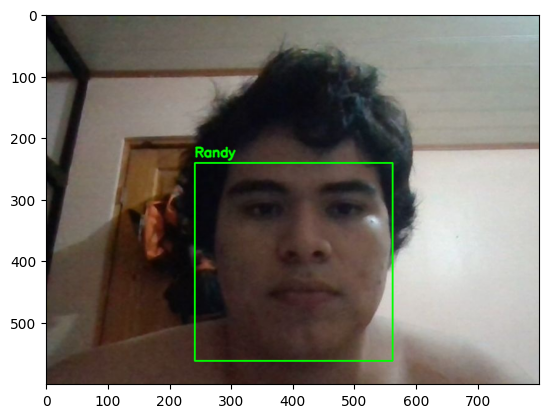


Type: Student
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone Book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Marital Status: married
Attendance Time: 2023-10-23 14



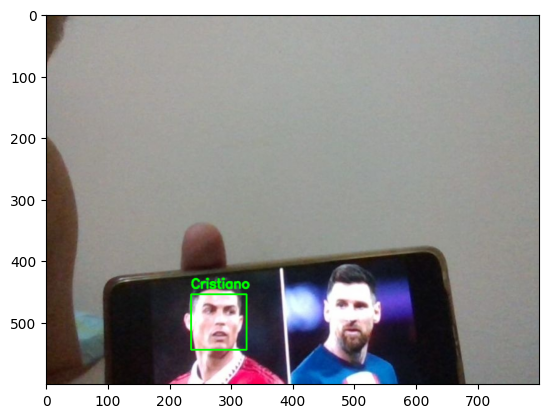


Type: Professor
Name: Messi 
ID: 9398383
Age: 36
Birthday: idnind
Nationality: aregentinian
Phone Book:
  mesu: 9938382
  ien: 939388
Emails:
  forvis@gmail.com
Address: ddwkek
Marital Status: married
Attendance Time: 2023-10-23 14



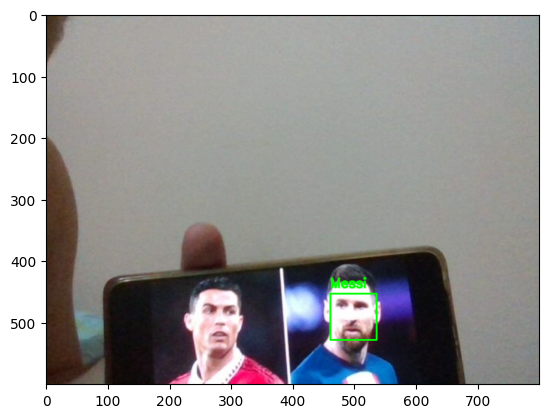

In [ ]:

def consulta11():
    """
    Indicates for a course at which time the most people reported and the number of people that attended.

    Args:
        registered_student(list): list of the students
        registered_professor(list): list of the teachers
        registered_miscelaneous(list): list of the miscellaneous

    Returns:
        student_info_list(list): list of student information dictionaries
    """
    # Creates a dictionary to easily access student, professor, and miscellaneous information by name
    all_people = {}

    # Combine all the people instances into one list
    all_people_instances = registered_student + registered_professor + registered_miscelaneous

    for person in all_people_instances:
        all_people[person.name] = person

    course_code = input("Enter the course code: ")

    # Dictionary to store attendance counts for each time slot
    time_slot_counts = {}

    # Iterates through the reported_attendance list
    for attendance in attendance_list3:
        for time_slot, attendance_data in attendance.items():
            if course_code in attendance_data:
                attendance_count = len(attendance_data[course_code])
                time_slot_counts[time_slot] = attendance_count

    # Finds the time slot with the most attendees
    max_attendance_time = max(time_slot_counts, key=time_slot_counts.get)
    max_attendance_count = time_slot_counts[max_attendance_time]

    if max_attendance_time:
        print(f"The time with the most attendees for course {course_code}: {max_attendance_time}")
        print(f"Number of attendees at that time: {max_attendance_count}")
        print("Attendees' Information:")

        # Iterates through attendance_list0 to find attendees at the specified time
        for attendance_data in attendance_list0:
            if course_code in attendance_data:
                attendance_list = attendance_data[course_code]

                # Iterates through attendees and display their information
                for person_info in attendance_list:
                    name, img_path, (top, right, bottom, left), attendance_time = person_info

                    # Checks if the reported person is a student, professor, or miscellaneous
                    if name in all_people:
                        person_instance = all_people[name]
                        person_type = "Student" if isinstance(person_instance, Estudiante) else "Professor" if isinstance(person_instance, Profesor) else "Miscellaneous"
                    else:
                        person_type = "Unknown"
                        person_instance = None

                    print(f"\nType: {person_type}")

                    if person_instance:
                        # Extract information directly from the instance
                        print(f"Name: {person_instance.name}")
                        print(f"ID: {person_instance.id}")
                        print(f"Age: {person_instance.age}")
                        print(f"Birthday: {person_instance.birthday}")
                        print(f"Nationality: {person_instance.nationality}")

                        # Print the contents of the Phone book without dictionary structure
                        print("Phone Book:")
                        for phone_key, phone_value in person_instance.phone_number.items():
                            print(f"  {phone_key}: {phone_value}")

                        # Print the contents of the Emails without list structure
                        print("Emails:")
                        for email in person_instance.emails:
                            print(f"  {email}")

                        print(f"Address: {person_instance.address}")
                        print(f"Marital Status: {person_instance.marital_status}")

                    print(f"Attendance Time: {attendance_time}")
                    print()
                    # Displays the image with a square on the face and the person's name
                    show_image(img_path, (top, right, bottom, left, name))

    else:
        print(f"No attendance records found for course code: {course_code}")

# Calls the function
consulta11()


## Consulta 12

In [ ]:


def quicksort(arr):
    """
    This function sorts a list of students based on their age using the quicksort algorithm.

    Args:
        arr (list): List of student instances

    Returns:
        list: Sorted list of student instances (from oldest to youngest)
    """
    if len(arr) <= 1:
        return arr
    else:
        pivot = arr[0]
        less = [x for x in arr[1:] if x.age <= pivot.age]
        greater = [x for x in arr[1:] if x.age > pivot.age]
        return quicksort(greater) + [pivot] + quicksort(less)

def consul12():
    """
    This function sorts the students enrolled in a specific course from oldest to youngest using the quicksort algorithm.

    Returns:
        None
    """
    codig = input("Write the code of the course: ")

    # Find the enrolled students in the specified course
    enrolled_students = []
    for course_dict in registered_students_in_courses:
        if codig in course_dict:
            enrolled_students = course_dict[codig]

    # Verify if students are enrolled in the course
    if not enrolled_students:
        print("No students are enrolled in this course.")
    else:
        # Create a list to store student instances in the same order as enrolled_students
        sorted_students = []

        # Match enrolled students with registered_student instances
        for student_name in enrolled_students:
            for student_instance in registered_student:
                if student_instance.name == student_name:
                    sorted_students.append(student_instance)
                    break  # Exit the inner loop after finding a match

        # Sort the list of student instances by age using the quicksort function
        sorted_students = quicksort(sorted_students)

        print("The enrolled students in this course from oldest to youngest are: ")
        # Print the information of the students
        for student_instance in sorted_students:
            print(f"Name: {student_instance.name}")
            print(f"ID: {student_instance.id}")
            print(f"Age: {student_instance.age}")
            print(f"Birthday: {student_instance.birthday}")
            print(f"Nationality: {student_instance.nationality}")

            # Print the contents of the Phone book without dictionary structure
            print("Phone book:")
            for pb_key, pb_value in student_instance.phone_number.items():
                print(f"  {pb_key}: {pb_value}")

            # Print the contents of the Emails without list structure
            print("Emails:")
            for email in student_instance.emails:
                print(f"  {email}")

            print(f"Address: {student_instance.address}")
            print(f"Career: {student_instance.carreer}")
            print(f"Marital Status: {student_instance.marital_status}\n")

# Calls the function
consul12()


Write the code of the course: IC001
The enrolled students in this course from oldest to youngest are: 
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Career: ing computtatino
Marital Status: married

Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Career: ing computation
Marital Status: alone



# Link de imagenes utilizadas y obtenidas

[Link a la carpeta de imagenes usadas e imagenes obtenidas](https://drive.google.com/drive/folders/1hA7QlFRvi8RJiykNM1jvPJhhH7FZoKPp?usp=sharing)